In [1]:
%run preprocessing.ipynb
%run evaluation.ipynb

In [2]:
import pandas as pd
import io
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sn
import numpy as np

In [4]:
fns = [_removeNumbers, _removeStopWords, _cleanLinks, _cleanAbbreviations, _removeSpecialChars, _removePunctuation, _lemmatization]

def trainModel():
    train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
    _saveClassDistribution(train)

    xtrain, ytrain = preprocess(train, fns)
    xtest, ytest = preprocess(test, fns)
    xval, yval = preprocess(val, fns)

    # WORD EMBEDDING
    
    makeTokenizer(xtrain)
    xtrain = textToSequences(xtrain)
    xtest = textToSequences(xtest)
    xval = textToSequences(xval)

    model = _makeModel()
    hist = model.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval))
    model.save('model\emotions.h5')
    print("Model saved on disk.")

    _testModel(model, xtest, ytest)
    _saveFigures(hist)
    plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

    return model

def _makeModel():
    model = Sequential()
    model.add(Embedding(input_dim=15212, output_dim=64, input_length=80))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def _testModel(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)
    xtest = textToSequences(xtest)
    model.evaluate(xtest, ytest)


    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport(model)


def getClassificationReport(model):
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)
    xtest = textToSequences(xtest)
    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 64)            973568    
                                                                 
 dropout (Dropout)           (None, 80, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 80, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

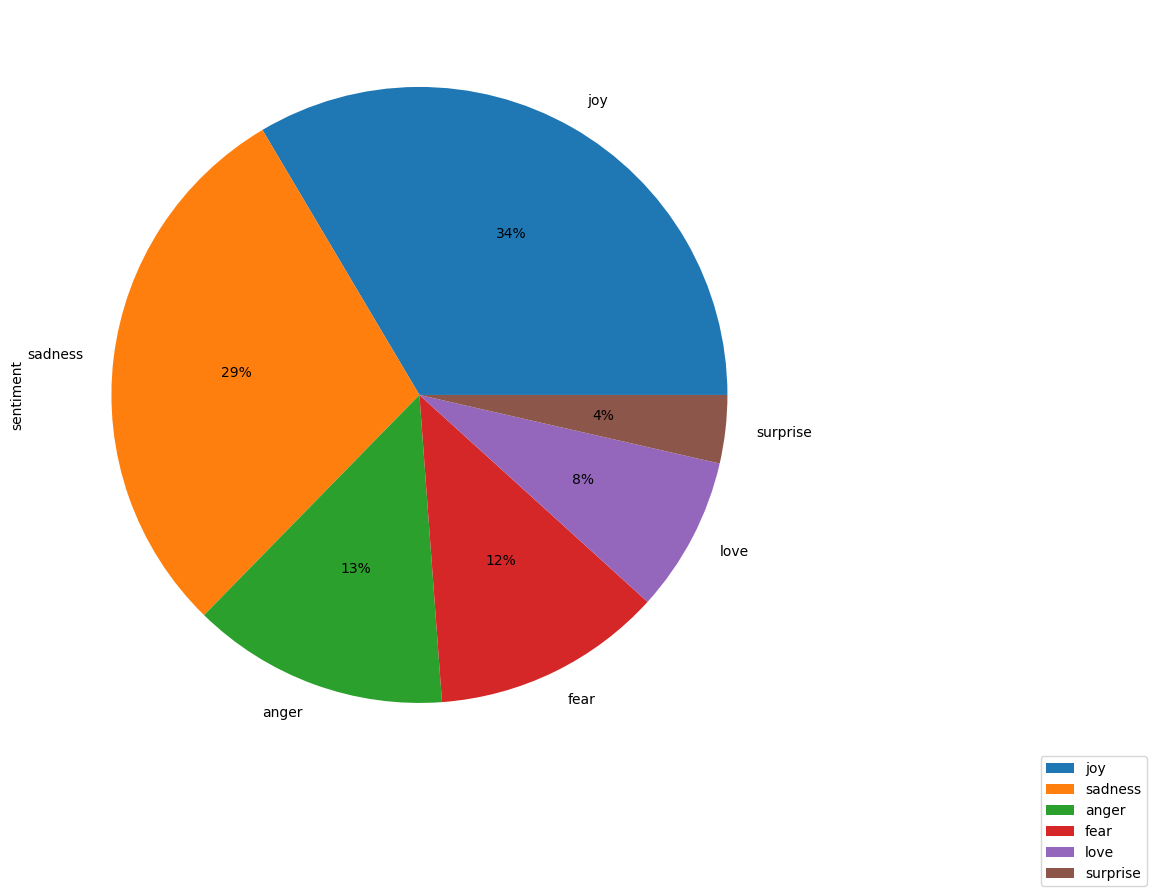

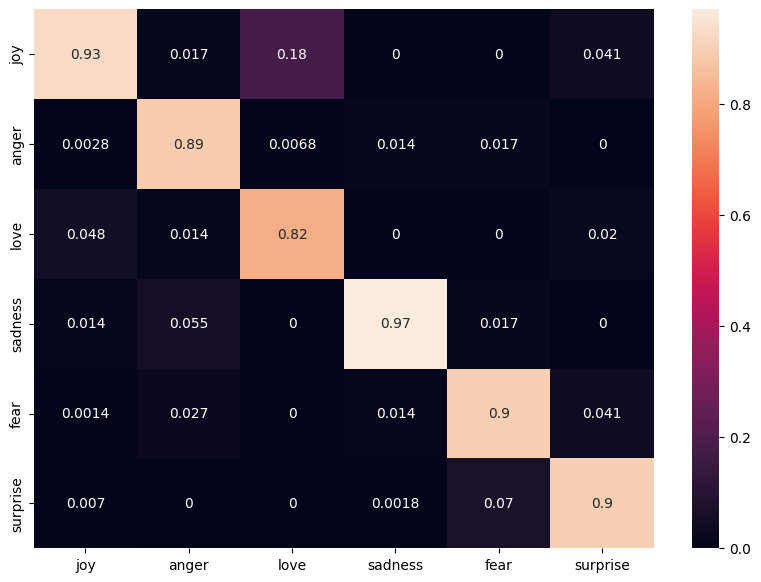

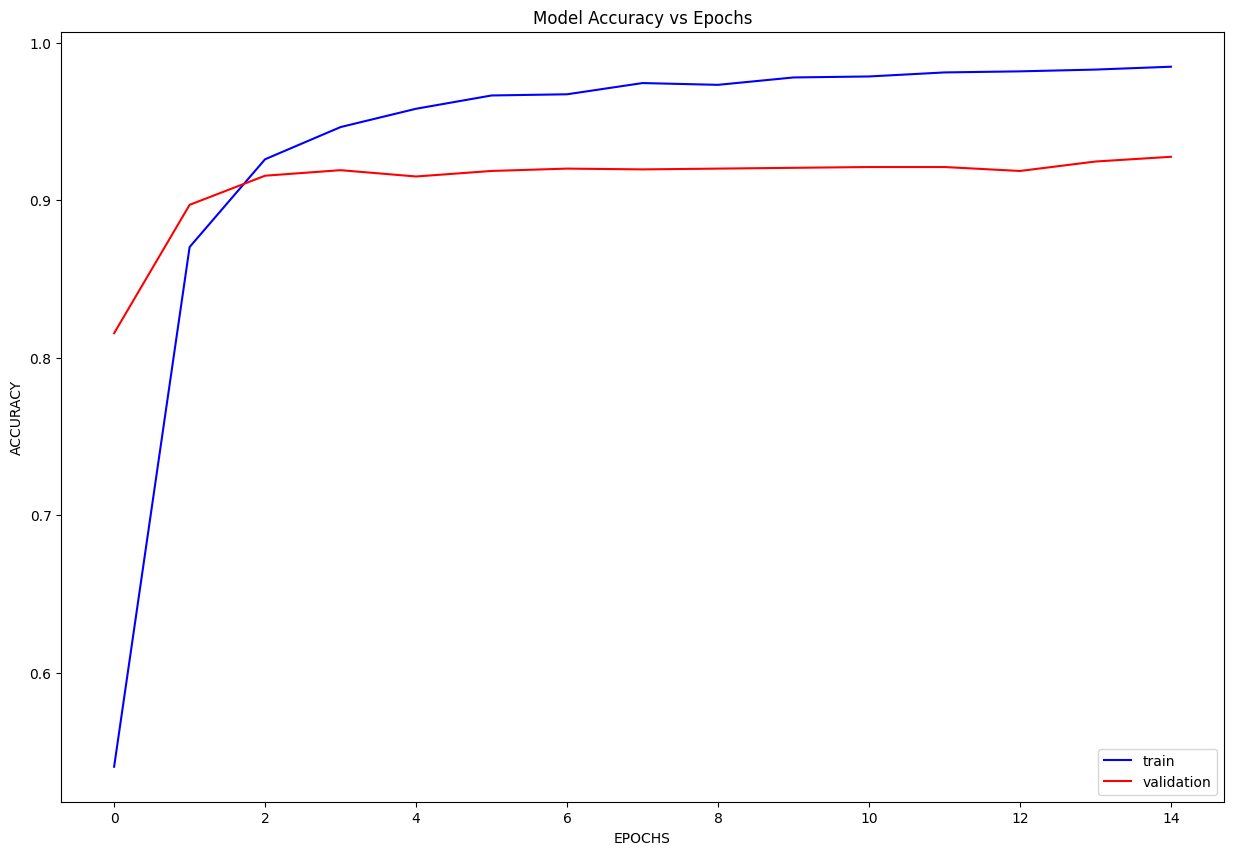

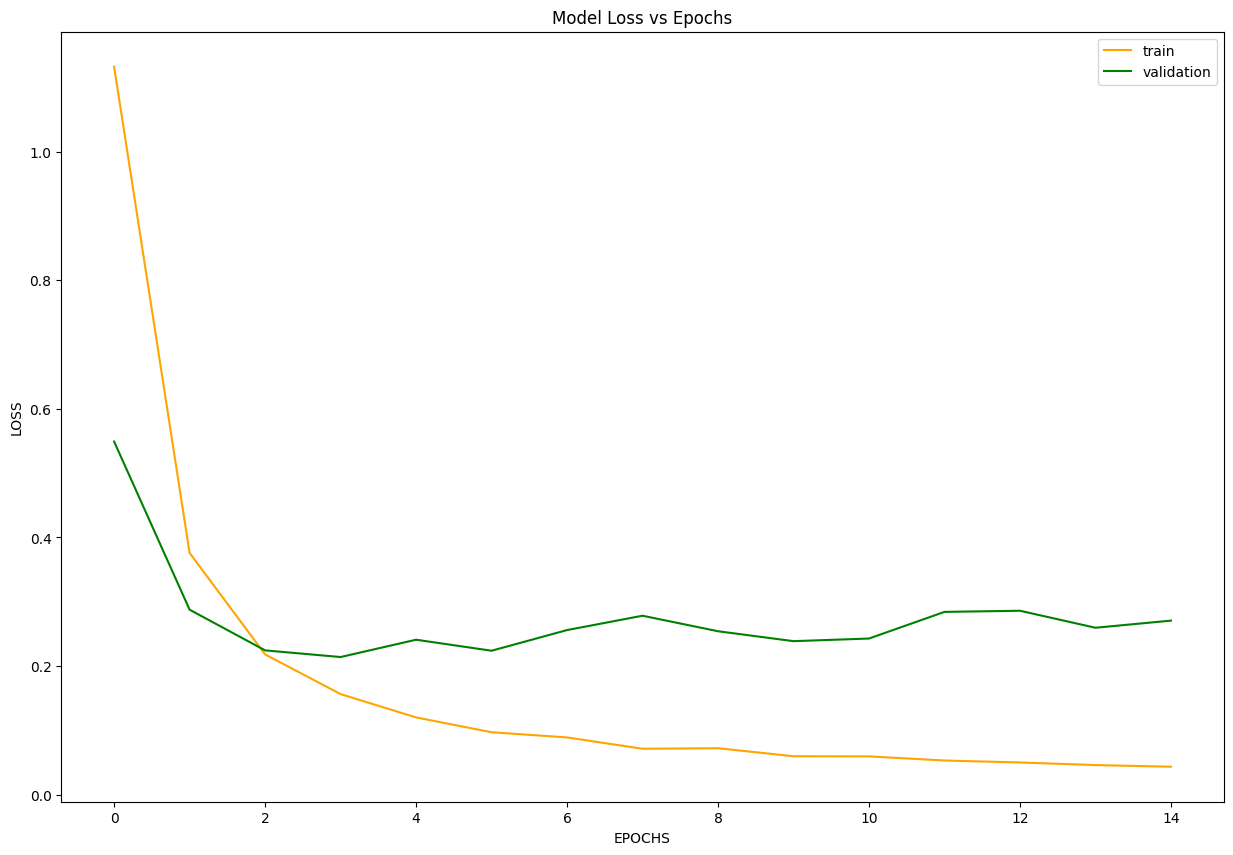

In [5]:
model = trainModel()   